   # Joining geographic data with Pandas and Geopandas

This notebook shows how to load geographic data and join various tables. It involves working with taxi data, census data, and census shapefiles. The American Community Survey (2017 5-year estimates) census data was downloaded from [American FactFinder](https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t). The 2017 census tract shapefiles were donwloaded from the [U.S. Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2017.html). And the taxi files were downloaded from the [Taxi and Limousine Commission site](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

## Importing the libraries

A note about the libraries: at the time of writing this tutorial, `Geopandas` automatically installs `Pyproj` version 2.2.0. This library was generating some errors while transforming from one projection to another. To fix this problem, use `pip` to uninstall this version of `Pyproj` and install a previous one:
* `pip uninstall pyproj`
* `pip install pyproj==2.1.3`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point

## Loading census tracts with `geopandas`

In [2]:
NewYorkStateCensusTracts = gpd.read_file('../input/tl_2017_36_tract.shp')

In [3]:
NewYorkStateCensusTracts.head()

STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      36      093  033102  36093033102  331.02  Census Tract 331.02  G5020   
1      36      093  020102  36093020102  201.02  Census Tract 201.02  G5020   
2      36      093  032504  36093032504  325.04  Census Tract 325.04  G5020   
3      36      081  003400  36081003400      34      Census Tract 34  G5020   
4      36      081  003900  36081003900      39      Census Tract 39  G5020   

  FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S  183329957  3232878  +42.7780137  -074.1727137   
1        S     854904        0  +42.8295375  -073.9161408   
2        S   65998560  1265253  +42.9010539  -074.0288936   
3        S     213987        0  +40.6847731  -073.8581871   
4        S     146970        0  +40.7627994  -073.9409316   

                                            geometry  
0  POLYGON ((-74.30655 42.750642, -74.30624499999...  
1  POLYGON ((-73.92513099999999 42.82029, -73.924...  
2  POLYGON ((-74.09298 42.955868, -74.08805199999...  
3  POLYGON ((-73.86629499999999 40.683189, -73.86...  
4  POLYGON ((-73.943304 40.760658, -73.942472 40....

## Selecting only the census tracts for New York City (`061`, `081`, `085`, `047`, `005`)

In [4]:
nycCTs = NewYorkStateCensusTracts[(NewYorkStateCensusTracts['COUNTYFP'] == '061') | (NewYorkStateCensusTracts['COUNTYFP'] == '081') | (NewYorkStateCensusTracts['COUNTYFP'] == '085') | (NewYorkStateCensusTracts['COUNTYFP'] == '047') | (NewYorkStateCensusTracts['COUNTYFP'] == '005')]

In [5]:
len(nycCTs)

2167

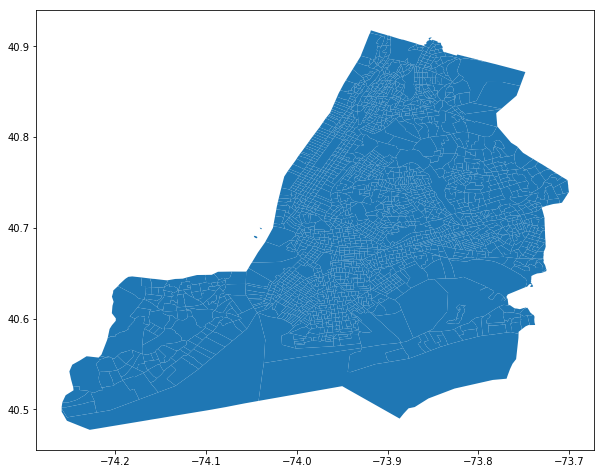

In [6]:
plt.rcParams["figure.figsize"] = [10, 10]
nycCTs.plot()

## Changing the projection of the census tracts

In [7]:
nycCTs.crs

{'init': 'epsg:4269'}

In [8]:
nycCTs = nycCTs.to_crs({'init': 'epsg:2263'})

In [9]:
nycCTs.crs

{'init': 'epsg:2263'}

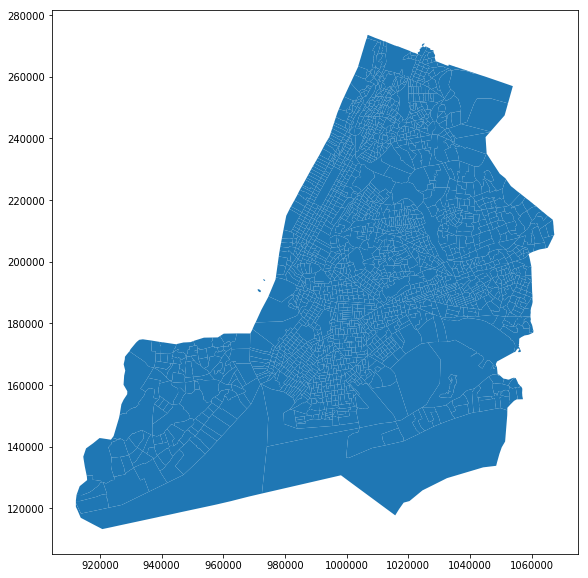

In [10]:
nycCTs.plot()

## Loading the census data file

In [11]:
censusData = pd.read_csv('../input/ACS_17_5YR_B19013.csv', delimiter=',', header=0)

In [12]:
censusData.head()

GEO.id      GEO.id2                        GEO.display-label  \
0  1400000US36005000100  36005000100   Census Tract 1, Bronx County, New York   
1  1400000US36005000200  36005000200   Census Tract 2, Bronx County, New York   
2  1400000US36005000400  36005000400   Census Tract 4, Bronx County, New York   
3  1400000US36005001600  36005001600  Census Tract 16, Bronx County, New York   
4  1400000US36005001900  36005001900  Census Tract 19, Bronx County, New York   

   HD01_VD01  HD02_VD01  
0        NaN        NaN  
1    62773.0    11556.0  
2    82697.0     8000.0  
3    33118.0     3520.0  
4    40117.0     4612.0

## Comparing data types in order to perform the join

Data types need to be of the same kind on the column (`GEO.id2` & `GEOID`) you will use to perform the join.

In [13]:
censusData.dtypes

GEO.id                object
GEO.id2                int64
GEO.display-label     object
HD01_VD01            float64
HD02_VD01            float64
dtype: object

In [14]:
nycCTs.dtypes

STATEFP     object
COUNTYFP    object
TRACTCE     object
GEOID       object
NAME        object
NAMELSAD    object
MTFCC       object
FUNCSTAT    object
ALAND        int64
AWATER       int64
INTPTLAT    object
INTPTLON    object
geometry    object
dtype: object

In this case, they are of different types. Therefore, I will create a new column with the right type and use that one to perform the join.

In [15]:
censusData['GEOID'] = censusData['GEO.id2'].astype('str')

In [16]:
censusData.head()

GEO.id      GEO.id2                        GEO.display-label  \
0  1400000US36005000100  36005000100   Census Tract 1, Bronx County, New York   
1  1400000US36005000200  36005000200   Census Tract 2, Bronx County, New York   
2  1400000US36005000400  36005000400   Census Tract 4, Bronx County, New York   
3  1400000US36005001600  36005001600  Census Tract 16, Bronx County, New York   
4  1400000US36005001900  36005001900  Census Tract 19, Bronx County, New York   

   HD01_VD01  HD02_VD01        GEOID  
0        NaN        NaN  36005000100  
1    62773.0    11556.0  36005000200  
2    82697.0     8000.0  36005000400  
3    33118.0     3520.0  36005001600  
4    40117.0     4612.0  36005001900

## Joining the tables

Here is a [diagram explaining the different types of joins](https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/) and Pandas' [merge documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

In [17]:
nycCTs = nycCTs.merge(censusData, how='left', left_on="GEOID", right_on="GEOID")

In [18]:
nycCTs.head()

STATEFP COUNTYFP TRACTCE        GEOID NAME         NAMELSAD  MTFCC FUNCSTAT  \
0      36      081  003400  36081003400   34  Census Tract 34  G5020        S   
1      36      081  003900  36081003900   39  Census Tract 39  G5020        S   
2      36      081  003600  36081003600   36  Census Tract 36  G5020        S   
3      36      081  003700  36081003700   37  Census Tract 37  G5020        S   
4      36      081  003800  36081003800   38  Census Tract 38  G5020        S   

    ALAND  AWATER     INTPTLAT      INTPTLON  \
0  213987       0  +40.6847731  -073.8581871   
1  146970       0  +40.7627994  -073.9409316   
2  180006       0  +40.6837714  -073.8568176   
3  386629   14591  +40.7624148  -073.9434494   
4  176214       0  +40.6847999  -073.8474941   

                                            geometry                GEO.id  \
0  POLYGON ((1021333.167256765 188208.8993688373,...  1400000US36081003400   
1  POLYGON ((999956.4090817941 216410.0252367666,...  1400000US36081003900   
2  POLYGON ((1021942.135297121 187912.5437250789,...  1400000US36081003600   
3  POLYGON ((997890.3169969544 214461.417697794, ...  1400000US36081003700   
4  POLYGON ((1025075.082022336 188602.5456460377,...  1400000US36081003800   

       GEO.id2                         GEO.display-label  HD01_VD01  HD02_VD01  
0  36081003400  Census Tract 34, Queens County, New York    71000.0    20471.0  
1  36081003900  Census Tract 39, Queens County, New York    43194.0     8336.0  
2  36081003600  Census Tract 36, Queens County, New York    79549.0    11590.0  
3  36081003700  Census Tract 37, Queens County, New York        NaN        NaN  
4  36081003800  Census Tract 38, Queens County, New York    73281.0    26350.0

## Creating a dataset of census tracts without any zeros 

In [19]:
nycClean = nycCTs[nycCTs['HD01_VD01'] > 0]

In [20]:
nycClean['MHHI'] = nycClean['HD01_VD01'].astype('int')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
nycClean.head()

STATEFP COUNTYFP TRACTCE        GEOID   NAME            NAMELSAD  MTFCC  \
0      36      081  003400  36081003400     34     Census Tract 34  G5020   
1      36      081  003900  36081003900     39     Census Tract 39  G5020   
2      36      081  003600  36081003600     36     Census Tract 36  G5020   
4      36      081  003800  36081003800     38     Census Tract 38  G5020   
5      36      081  004001  36081004001  40.01  Census Tract 40.01  G5020   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  213987       0  +40.6847731  -073.8581871   
1        S  146970       0  +40.7627994  -073.9409316   
2        S  180006       0  +40.6837714  -073.8568176   
4        S  176214       0  +40.6847999  -073.8474941   
5        S  174292       0  +40.6832481  -073.8458743   

                                            geometry                GEO.id  \
0  POLYGON ((1021333.167256765 188208.8993688373,...  1400000US36081003400   
1  POLYGON ((999956.4090817941 216410.0252367666,...  1400000US36081003900   
2  POLYGON ((1021942.135297121 187912.5437250789,...  1400000US36081003600   
4  POLYGON ((1025075.082022336 188602.5456460377,...  1400000US36081003800   
5  POLYGON ((1025539.698498705 188077.2390209451,...  1400000US36081004001   

       GEO.id2                            GEO.display-label  HD01_VD01  \
0  36081003400     Census Tract 34, Queens County, New York    71000.0   
1  36081003900     Census Tract 39, Queens County, New York    43194.0   
2  36081003600     Census Tract 36, Queens County, New York    79549.0   
4  36081003800     Census Tract 38, Queens County, New York    73281.0   
5  36081004001  Census Tract 40.01, Queens County, New York    72250.0   

   HD02_VD01   MHHI  
0    20471.0  71000  
1     8336.0  43194  
2    11590.0  79549  
4    26350.0  73281  
5    21270.0  72250

## Mapping the median household income in each census tract

Documentation on Matplotlib's different color ramps can be found [here](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)

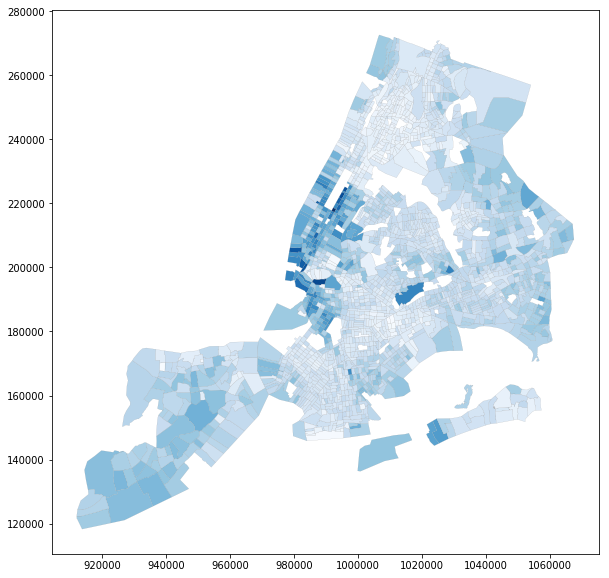

In [22]:
nycClean.plot(column='MHHI', cmap='Blues', linewidth=0.1, edgecolor='0.5')
plt.show()

## Loading a sample of taxi data (100,000 randomly selected rides)

In [23]:
taxiSample = pd.read_csv('../input/TaxiSample_2013_10.csv', delimiter=',')

In [24]:
taxiSample.shape

(100000, 19)

In [25]:
taxiSample.head()

Unnamed: 0 vendor_id      pickup_datetime     dropoff_datetime  \
0     6463382       VTS  2013-10-01 07:10:00  2013-10-01 07:23:00   
1     3959086       CMT  2013-10-22 12:39:33  2013-10-22 12:53:47   
2     4318338       CMT  2013-10-25 13:55:45  2013-10-25 13:59:04   
3    13891146       CMT  2013-10-02 18:41:38  2013-10-02 18:45:18   
4     4464588       CMT  2013-10-24 14:40:05  2013-10-24 14:46:13   

   passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           2.81        -73.986260        40.734592   
1                1           1.00        -73.981446        40.765865   
2                2           0.00        -73.947737        40.772811   
3                1           1.00        -73.949122        40.781575   
4                1           0.70        -73.972321        40.765193   

   rate_code store_and_fwd_flag  dropoff_longitude  dropoff_latitude  \
0          1                NaN         -74.013570         40.714595   
1          1                  N         -73.982812         40.753442   
2          1                  N         -73.947136         40.772706   
3          1                  N         -73.955284         40.769184   
4          1                  N         -73.981999         40.770587   

  payment_type  fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  \
0          CRD         13.0        0.0      0.5         2.6           0.0   
1          CSH          9.5        0.0      0.5         0.0           0.0   
2          CSH          3.5        0.0      0.5         0.0           0.0   
3          CRD          5.0        1.0      0.5         2.5           0.0   
4          CSH          5.5        0.0      0.5         0.0           0.0   

   total_amount  
0          16.1  
1          10.0  
2           4.0  
3           9.0  
4           6.0

## Creating a geographic dataframe from the taxi sample

First, we need to create a `geometry` list with points using the `shapely` library. In this case I will use the dropoff coordinates.

In [26]:
geometry = [Point(xy) for xy in zip(taxiSample.dropoff_longitude, taxiSample.dropoff_latitude)]

In [27]:
geometry

 ...]

Second, I will create the geodataframe for the taxi samples using that `geometry` list and making sure the crs is the appropriate for those coordinates. This crs is based on the actual taxi data, later we will convert it to make it match the New York City one.

In [28]:
crs = {'init': 'epsg:4326'}
taxiSample = gpd.GeoDataFrame(taxiSample, crs=crs, geometry=geometry)

In [29]:
taxiSample.head()

Unnamed: 0 vendor_id      pickup_datetime     dropoff_datetime  \
0     6463382       VTS  2013-10-01 07:10:00  2013-10-01 07:23:00   
1     3959086       CMT  2013-10-22 12:39:33  2013-10-22 12:53:47   
2     4318338       CMT  2013-10-25 13:55:45  2013-10-25 13:59:04   
3    13891146       CMT  2013-10-02 18:41:38  2013-10-02 18:45:18   
4     4464588       CMT  2013-10-24 14:40:05  2013-10-24 14:46:13   

   passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           2.81        -73.986260        40.734592   
1                1           1.00        -73.981446        40.765865   
2                2           0.00        -73.947737        40.772811   
3                1           1.00        -73.949122        40.781575   
4                1           0.70        -73.972321        40.765193   

   rate_code store_and_fwd_flag  dropoff_longitude  dropoff_latitude  \
0          1                NaN         -74.013570         40.714595   
1          1                  N         -73.982812         40.753442   
2          1                  N         -73.947136         40.772706   
3          1                  N         -73.955284         40.769184   
4          1                  N         -73.981999         40.770587   

  payment_type  fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  \
0          CRD         13.0        0.0      0.5         2.6           0.0   
1          CSH          9.5        0.0      0.5         0.0           0.0   
2          CSH          3.5        0.0      0.5         0.0           0.0   
3          CRD          5.0        1.0      0.5         2.5           0.0   
4          CSH          5.5        0.0      0.5         0.0           0.0   

   total_amount                              geometry  
0          16.1           POINT (-74.01357 40.714595)  
1          10.0  POINT (-73.98281199999998 40.753442)  
2           4.0          POINT (-73.947136 40.772706)  
3           9.0  POINT (-73.95528399999999 40.769184)  
4           6.0          POINT (-73.981999 40.770587)

Finally, we need to clean the dataset by removing any trips where the latitute or longitude is outside our bounds.

In [30]:
cleanTaxiSample = taxiSample[taxiSample['dropoff_latitude'] > 40.4]
cleanTaxiSample = cleanTaxiSample[cleanTaxiSample['dropoff_latitude'] < 40.95]
cleanTaxiSample = cleanTaxiSample[cleanTaxiSample['dropoff_longitude'] > -74.3]
cleanTaxiSample = cleanTaxiSample[cleanTaxiSample['dropoff_longitude'] < -73.65]

In [31]:
len(cleanTaxiSample)

98824

Now we can convert the taxi sample to the appropriate NYC projection and map it.

In [32]:
cleanTaxiSample = cleanTaxiSample.to_crs({'init': 'epsg:2263'})

In [33]:
cleanTaxiSample.crs

{'init': 'epsg:2263'}

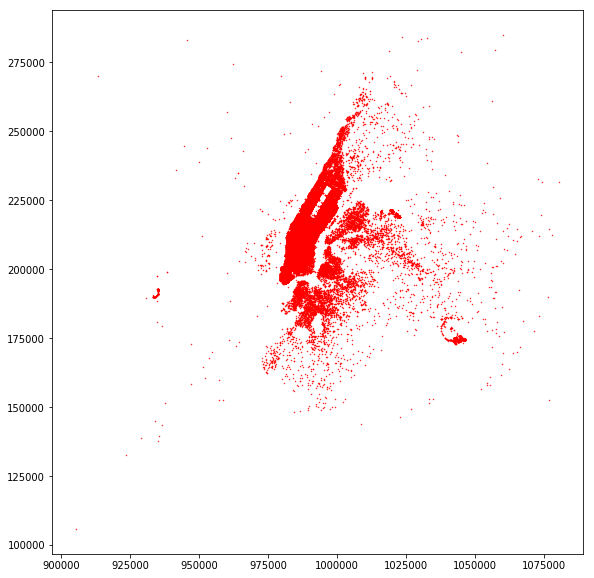

In [34]:
cleanTaxiSample.plot(color='red', markersize=0.2)

## Overlaying to datasets on a map (plot)

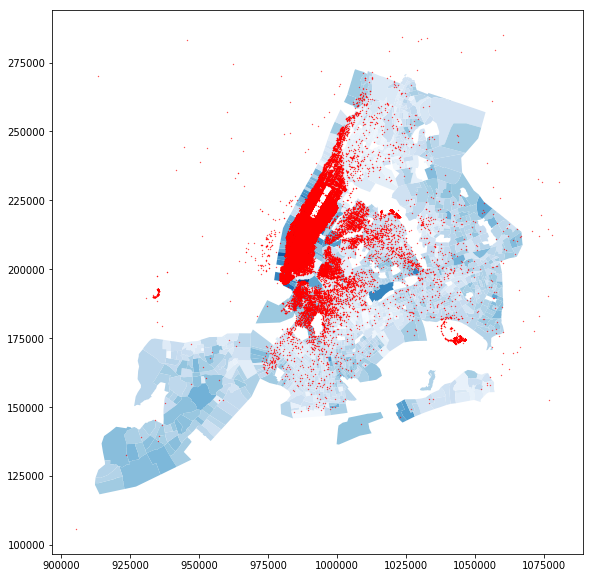

In [35]:
fig, ax = plt.subplots()
nycClean.plot(column='MHHI', ax=ax, cmap='Blues')
cleanTaxiSample.plot(color='red',ax=ax, markersize=0.1)
plt.show()

## Merging datasets based on spatial location

In [36]:
nycCensusTaxis = gpd.sjoin(nycClean, cleanTaxiSample, how='left', op='intersects')

In [37]:
nycCensusTaxis.shape

(92906, 39)

In [38]:
nycCensusTaxis.head()

STATEFP COUNTYFP TRACTCE        GEOID NAME         NAMELSAD  MTFCC FUNCSTAT  \
0      36      081  003400  36081003400   34  Census Tract 34  G5020        S   
1      36      081  003900  36081003900   39  Census Tract 39  G5020        S   
1      36      081  003900  36081003900   39  Census Tract 39  G5020        S   
1      36      081  003900  36081003900   39  Census Tract 39  G5020        S   
1      36      081  003900  36081003900   39  Census Tract 39  G5020        S   

    ALAND  AWATER  ... store_and_fwd_flag dropoff_longitude dropoff_latitude  \
0  213987       0  ...                NaN               NaN              NaN   
1  146970       0  ...                NaN        -73.942118        40.761825   
1  146970       0  ...                NaN        -73.941955        40.761852   
1  146970       0  ...                NaN        -73.940365        40.762235   
1  146970       0  ...                  N        -73.940812        40.763547   

  payment_type  fare_amount surcharge  mta_tax  tip_amount  tolls_amount  \
0          NaN          NaN       NaN      NaN         NaN           NaN   
1          CRD         11.0       0.5      0.5         2.3           0.0   
1          CSH         14.0       0.5      0.5         0.0           0.0   
1          CSH          8.0       0.0      0.5         0.0           0.0   
1          CSH          7.0       0.0      0.5         0.0           0.0   

   total_amount  
0           NaN  
1          14.3  
1          15.0  
1           8.5  
1           7.5  

[5 rows x 39 columns]

## Calculating new fields and creating a pivot table

The resulting dataframe (after the merge) contains one line per taxi trip, with the associated census tract information. In fact, the census tract lines got duplicated to match the number of taxi trips. We will aggregate them now by creating a `pivot table`.

In [39]:
nycCensusTaxis['tip_perc'] = nycCensusTaxis['tip_amount'] / nycCensusTaxis['fare_amount']

In [40]:
nycCensusTaxis['tip_perc'].sort_values(ascending=False)

1854    13.466667
1114     9.600000
519      9.400000
1863     9.101818
1858     6.000000
1854     4.800000
1867     4.800000
524      4.562857
384      3.333333
1888     3.285455
883      2.800000
597      2.693333
934      2.600000
662      2.113333
1849     2.000000
1523     2.000000
1867     2.000000
639      2.000000
519      1.847692
654      1.818182
1905     1.704516
1836     1.666667
576      1.666667
1806     1.600000
601      1.538462
1827     1.538462
633      1.538462
1868     1.538462
658      1.500000
1823     1.500000
          ...    
2075          NaN
2078          NaN
2080          NaN
2081          NaN
2082          NaN
2083          NaN
2086          NaN
2087          NaN
2088          NaN
2090          NaN
2092          NaN
2093          NaN
2094          NaN
2095          NaN
2097          NaN
2098          NaN
2102          NaN
2104          NaN
2106          NaN
2107          NaN
2110          NaN
2112          NaN
2131          NaN
2140          NaN
2142      

In [41]:
pivotTable = nycCensusTaxis.pivot_table(index='GEOID',
values=['MHHI', 'tip_perc', 'vendor_id'],
aggfunc={'vendor_id':'count', 'tip_perc':'mean', 'MHHI':'mean'})

In [42]:
pivotTable.head()

MHHI  tip_perc  vendor_id
GEOID                                  
36005000200  62773       NaN          0
36005000400  82697  0.202198          1
36005001600  33118  0.000000          1
36005001900  40117  0.074850          8
36005002000  18370       NaN          0

In [43]:
pivotTable = pivotTable.rename(index=str, columns={"vendor_id": "taxiTrips"})

In [44]:
pivotTable.head()

MHHI  tip_perc  taxiTrips
GEOID                                  
36005000200  62773       NaN          0
36005000400  82697  0.202198          1
36005001600  33118  0.000000          1
36005001900  40117  0.074850          8
36005002000  18370       NaN          0

In [45]:
pivotTable.sort_values('MHHI', ascending=False)

MHHI  tip_perc  taxiTrips
GEOID                                   
36061011401  233646  0.093499        541
36047002100  212159  0.130185        153
36061014200  208024  0.099101        582
36061015002  205145  0.088816        491
36061003100  202404  0.117538        225
36061006900  198636  0.147260        236
36061003300  193750  0.110397        590
36061013000  190208  0.093436        615
36061014700  190167  0.110055        114
36061012000  187292  0.102863        618
36061005800  183988  0.128714        822
36061000900  180547  0.101383        452
36061008603  167607  0.109493        215
36061010200  167500  0.097879       1141
36061016700  165753  0.103501        357
36061012800  165049  0.100542        649
36061011202  163750  0.118927        611
36061031704  162030  0.107861        428
36081074900  161750  0.187760          3
36047000900  161144  0.126056         87
36061010900  160511  0.095603        733
36081056100  160250       NaN          0
36061005501  160121  0.118843        231
36061005200  159821  0.129926        760
36061014500  159222  0.111737        712
36047006700  158194  0.134157         31
36061003900  157652  0.133100        527
36047000700  157534  0.161422         55
36061005700  157176  0.117916        313
36061012200  156827  0.093012        520
...             ...       ...        ...
36047111000   17854  0.081081          1
36047048900   17518  0.208696          1
36061002500   17500  0.106708          9
36005005200   17454  0.000000          1
36005002300   17426  0.000000          2
36047110600   17405       NaN          0
36005002701   17383  0.000000          1
36061019200   17304  0.018972         11
36005015300   17154  0.142857          2
36061019600   17070  0.094483        121
36047092000   17016       NaN          0
36047025902   16448  0.210811          1
36047115600   16404  0.203390          1
36061011900   16394  0.092426        968
36005014300   15060       NaN          0
36005020502   14821  0.000000          1
36061002000   14745  0.064664         33
36005016100   14667       NaN          0
36047091200   14347       NaN          0
36061002400   14300  0.069619         17
36005005300   13519       NaN          0
36085013301   13485       NaN          0
36005002702   13216  0.011364          4
36047008500   13207  0.158214          4
36047035200   12302       NaN          0
36047091000   11560  0.000000          1
36047090800   10767       NaN          0
36047080800   10729       NaN          0
36047090600   10693       NaN          0
36085031901    9053       NaN          0

[2101 rows x 3 columns]

## Plotting average tip percentage vs. median household income of each census tracts

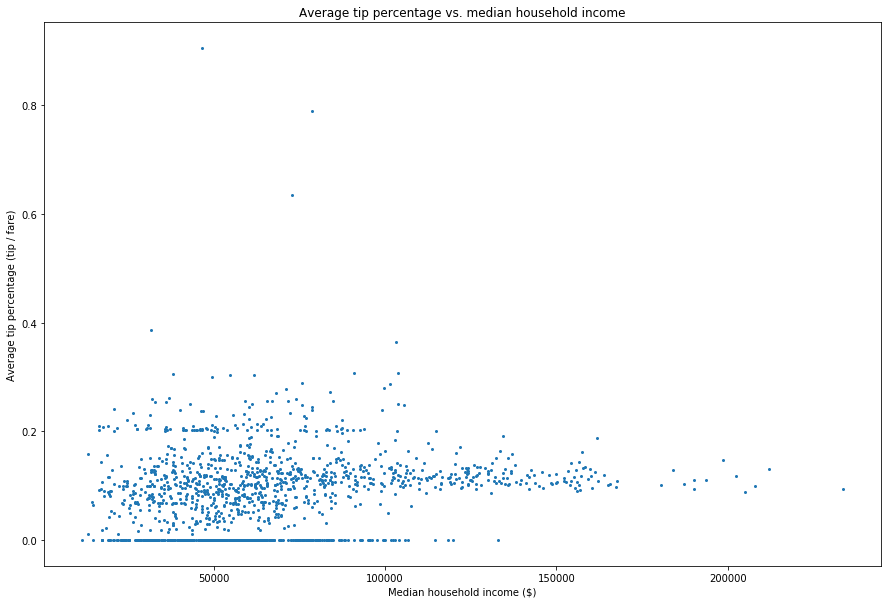

In [67]:
plt.rcParams["figure.figsize"] = [15, 10]
plt.scatter(pivotTable['MHHI'], pivotTable['tip_perc'], s=4)
plt.title('Average tip percentage vs. median household income')
plt.ylabel('Average tip percentage (tip / fare)')
plt.xlabel('Median household income ($)')
plt.show()